# Titanic: Machine Learning from Disaster

## 结果

训练集最高得分：0.801372，采用决策树(DecisionTree)测试集得分为：0.7703
![myscole](C:/Users/incipient/Desktop/test_score_kaggle.png myscole)

## 数据清洗

In [1]:
import pandas as pd
import numpy as np
from sklearn import tree
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline

In [2]:
titanic = pd.read_csv('E:\\Python_learning\\learning_DC\\chapter_4\\train.csv')
s = '平均生存概率：{0:.2f} %'.format(titanic.describe().loc['mean','Survived'] * 100)
s

'平均生存概率：38.38 %'

假设在`'Survived'`中全部填零，预测的正确率差不多也有`61.61% == 1 - 平均生存概率`

In [3]:
titanic['sex'] = titanic['Sex']
titanic.loc[titanic['sex'] == 'female','sex'] = 0
titanic.loc[titanic['sex'] == 'male','sex'] = 1
titanic.sample(6)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex
301,302,1,3,"McCoy, Mr. Bernard",male,NaN,2,0,367226,23.25,NaN,Q,1
356,357,1,1,"Bowerman, Miss. Elsie Edith",female,22.0,0,1,113505,55.00,E33,S,0
668,669,0,3,"Cook, Mr. Jacob",male,43.0,0,0,A/5 3536,8.05,NaN,S,1
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S,1
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.50,NaN,S,1
812,813,0,2,"Slemen, Mr. Richard James",male,35.0,0,0,28206,10.50,NaN,S,1


`.loc(行索引,列索引)`返回满足索引条件的值(只有一个时)或者DataFrame，默认优先采用自定义索引，无自定义索引时采用系统索引，相反的时`iloc`

将Sex中的值数字化，也可以采用LabelEncoder，代码如下：
```
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(titanic['sex'])
le.transform(titanic['sex'])
```
但是用le有可能指定male为0，所以手动指定

In [4]:
titanic.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


`.describe()`输出的结果仍然是`pandas.core.frame.DataFrame`对象，用来整体描述数据中值全部为数字的列

In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
sex            891 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 90.6+ KB


`Age`这列中有NaN，需要单独处理NaN的值；
`Embarked`这一列有2个空值，需要单独处理；
`.info()`生成的仍然是`Nonetype`对象，所以不能对它进行切片、定位操作；

In [6]:
titanic['Title'] = titanic.Name.str.extract(' ([A-Za-z]+)\.',expand=False)
pd.crosstab(titanic['Title'],titanic['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


`.extract(' ([A-Za-z]+)\.',expand=False)`从字符串中提取出符合正则表达式`' ([A-Za-z]+)\.'`的字符串，目的是从`Name`中把称谓提取出来；
`pandas.crosstab(index,columns)`默认计算两个或多个factor(因子)出现的频次。Title中值不一样但是意思一样的，需要合并，例如Mme和Mrs，Mlle、Ms和Miss；出现频次很少，意思又不一样的，统一成一类。

In [7]:
titanic['Title'] = titanic['Title'].replace(['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
titanic['Title'] = titanic['Title'].replace(['Mlle','Ms'], 'Miss')
titanic['Title'] = titanic['Title'].replace('Mme', 'Mrs')

`.repalce(消失值,返回值)`

In [8]:
titanic['title'] = titanic['Title']
titanic.loc[titanic['Title'] == 'Master','title'] = 0
titanic.loc[titanic['Title'] == 'Miss','title'] = 1
titanic.loc[titanic['Title'] == 'Mr','title'] = 2
titanic.loc[titanic['Title'] == 'Mrs','title'] = 3
titanic.loc[titanic['Title'] == 'Rare','title'] = 4

In [9]:
titanic['embarked'] = titanic['Embarked']
titanic['embarked'] = titanic['embarked'].replace('S',int(0))
titanic['embarked'] = titanic['embarked'].replace('C',int(1))
titanic['embarked'] = titanic['embarked'].replace('Q',int(2))
titanic['embarked'].fillna(3,inplace=True)

`.fillna()`用新值替换值为空NaN的，当然上面也可以采用`.loc`的方法

In [10]:
titanic[['embarked','Survived']].groupby(
    'embarked',as_index=False).mean().sort_values(by='Survived',ascending=False)

,embarked,Survived
3,3.0,1.000000
1,1.0,0.553571
2,2.0,0.389610
0,0.0,0.336957


生存率在不同登船口岸中也有差异；
`.groupby()`分类汇总，返回一个DF对象；`.mean()`DF中的值为每个类所有值的期望；`sort_values(by,axis=0,ascending=True)`默认根据by这个索引在axis轴进行升序排序。

In [11]:
titanic['embarked'].count()

891

经过替换，embarked中无空值NaN

In [12]:
titanic.sample(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex,Title,title,embarked
153,154,0,3,"van Billiard, Mr. Austin Blyler",male,40.5,0,2,A/5. 851,14.5,NaN,S,1,Mr,2,0.0
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S,1,Mr,2,0.0
841,842,0,2,"Mudd, Mr. Thomas Charles",male,16.0,0,0,S.O./P.P. 3,10.5,NaN,S,1,Mr,2,0.0
416,417,1,2,"Drew, Mrs. James Vivian (Lulu Thorne Christian)",female,34.0,1,1,28220,32.5,NaN,S,0,Mrs,3,0.0


In [13]:
guess_ages = np.zeros((2,3))
for i in range(2):
    for j in range(3):
        guess_df = titanic[(titanic['sex']==i) & 
                           (titanic['Pclass']==j+1)]['Age'].dropna()
        age_guess = guess_df.median()
        guess_ages[i,j] = int( age_guess/0.5 +0.5 ) * 0.5

guess_ages

array([[ 35. ,  28. ,  21.5],
       [ 40. ,  30. ,  25. ]])

根据sex、Pclass分类，得出每个类中的年龄的中位数，然后再用中位数去代替Age中的空值；

In [14]:
for i in range(2):
    for j in range(3):
        titanic.loc[(titanic.Age.isnull() & (titanic['sex']==i) & 
                           (titanic['Pclass']==j+1),'Age')] = guess_ages[i,j]
        

In [15]:
titanic.age = titanic.Age.astype(int)

In [16]:
titanic.loc[titanic.age <=12 ,'age'] = 1
titanic.loc[(titanic.age >12) & (titanic.age <= 18),'age'] = 2
titanic.loc[(titanic.age >18) & (titanic.age <= 32),'age'] = 3
titanic.loc[(titanic.age >32) & (titanic.age <= 60),'age'] = 4
titanic.loc[(titanic.age >60) & (titanic.age <= 80),'age'] = 5

In [17]:
titanic[['age','Survived']].groupby('age',as_index=False).mean()

,age,Survived
0,1.0,0.579710
1,2.0,0.428571
2,3.0,0.333333
3,4.0,0.419708
4,5.0,0.227273


不同年龄段生存率是有差异的，壮年段(3)的生存率低于平均值，其它都比平均值高，体现了人性的光辉

In [18]:
titanic['isalone'] = 0
titanic.loc[(titanic['Parch'] + titanic['SibSp']) == 0,'isalone'] = 1

`isalone`在船上是否孤身一人，如果它的父母孩子(Parch)数量与亲戚(SibSp)数量和为0，那么其为孤身

In [19]:
titanic[['isalone','Survived']].groupby('isalone',as_index=False).mean()

,isalone,Survived
0,0,0.505650
1,1,0.303538


孤身一人的生存概率低

In [20]:
titanic['age*pclass'] = titanic['age'] * titanic.Pclass

In [21]:
titanic.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [22]:
titanic['age'].value_counts()

3.0    456
4.0    274
2.0     70
1.0     69
5.0     22
Name: age, dtype: int64

In [23]:
titanic[['age*pclass','Survived']].groupby(
    'age*pclass',as_index=False).mean().sort_values(by='Survived',ascending=False)

,age*pclass,Survived
1,2.0,0.965517
0,1.0,0.750000
3,4.0,0.602740
2,3.0,0.570000
6,8.0,0.412698
5,6.0,0.370370
8,10.0,0.333333
7,9.0,0.247619
4,5.0,0.214286
10,15.0,0.200000


`age*pclass`将年龄和地位单独特征放大了，年龄大，地位低的存活率低

In [24]:
fareband_count = 10
titanic['fareband'] = pd.qcut(titanic['Fare'],fareband_count)

fare_line_data = titanic[['fareband','Survived']].groupby('fareband',\
as_index=False).mean()

fare_line_data

,fareband,Survived
0,"(-0.001, 7.55]",0.141304
1,"(7.55, 7.854]",0.298851
2,"(7.854, 8.05]",0.179245
3,"(8.05, 10.5]",0.230769
4,"(10.5, 14.454]",0.428571
5,"(14.454, 21.679]",0.420455
6,"(21.679, 27.0]",0.516854
7,"(27.0, 39.688]",0.373626
8,"(39.688, 77.958]",0.528090
9,"(77.958, 512.329]",0.758621


`pandas.qcut()`将维度为1的数据根据值排序后，再切成份，每份同样本数量。返回结果中的值`(-0.001, 7.55]`是`pandas.interval`对象，它有以下属性：
* closed  哪一侧的数被包含在内
* closed_left、open_left	、open_right、closed_right  返回bool值
* left、right	返回左侧值，是一个numpy数，需要转成python中的数才能互相使用
* mid	返回每个区间的中位数

In [25]:
titanic.fareband_num = titanic['Fare'].astype('float')

In [26]:
for i in range(fareband_count-1):
    left = fare_line_data.loc[i,'fareband'].left
    left = float(left)
    right = fare_line_data.loc[i,'fareband'].right
    right = float(right)
    titanic.loc[(titanic.fareband_num > left) & 
                (titanic.fareband_num <= right),'fareband_num'] = 1 + i

titanic.loc[titanic.fareband_num > right,'fareband_num'] = fareband_count

分段完成后将每段参数化；
因为分段时右边界为closed(']'),为了防止在分界点处小数点的影响，所以在分界的最右应单独处理；
整体趋势：船费越贵，存活率越高

In [27]:
titanic[['fareband_num','Survived']].groupby('fareband_num',as_index=False).mean()

,fareband_num,Survived
0,1.0,0.141304
1,2.0,0.310811
2,3.0,0.184874
3,4.0,0.230769
4,5.0,0.454545
5,6.0,0.404255
6,7.0,0.511111
7,8.0,0.373626
8,9.0,0.511628
9,10.0,0.766667


In [28]:
y = titanic[['Survived','SibSp','Parch','sex','title',
             'embarked','isalone','age*pclass','fareband_num']]
y = y.corr()
y

,Survived,SibSp,Parch,embarked,isalone,age*pclass,fareband_num
Survived,1.000000,-0.035322,0.081629,0.118026,-0.203367,-0.365466,0.323214
SibSp,-0.035322,1.000000,0.414838,-0.063794,-0.584471,-0.174199,0.358643
Parch,0.081629,0.414838,1.000000,-0.082144,-0.583398,-0.146568,0.369870
embarked,0.118026,-0.063794,-0.082144,1.000000,0.025927,0.000494,-0.037441
isalone,-0.203367,-0.584471,-0.583398,0.025927,1.000000,0.310023,-0.538914
age*pclass,-0.365466,-0.174199,-0.146568,0.000494,0.310023,1.000000,-0.644792
fareband_num,0.323214,0.358643,0.369870,-0.037441,-0.538914,-0.644792,1.000000


`.corr()`Pearson相关系数，形成相关系数矩阵，默认的是皮尔逊相关系数`method='pearson'`，返回值的范围是：[-1,1]。还有其它的方法：`'kendall'、'spearman'`。皮尔逊相关系数值对应的相关性程度如下：

|返回值的绝对值|相关性程度|
|------|-------|
|0.8 ~ 1.0|极强|
|0.6 ~ 0.8|强|
|0.4 ~ 0.6|中|
|0.2 ~ 0.4|弱|
|0   ~ 0.2|极弱，无关|

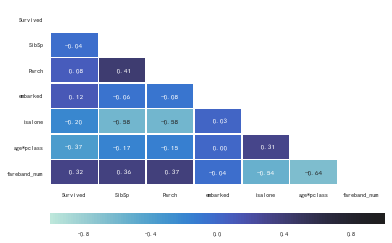

In [29]:
sns.set(style='whitegrid',font_scale=0.6,font='SimHei')
matplotlib.rcParams['axes.unicode_minus']=False
plt.subplots_adjust(left=0.15,right=0.9,
                    bottom=0.1, top=0.9)

grid_kws = {"height_ratios": (.85, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
mask = np.zeros_like(y)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(y,mask=mask,square=False,vmin=-1,vmax=1,\
            robust=True,annot=True,center=1,linewidth=0.5,fmt='>5.2f',ax=ax,
            cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})

plt.savefig('E:/MySQL_data/titanic_survival_exploration-master/titanic_pearson.jpg',dpi=600)  

* 整体设置图的基本情况
```
sns.set(
context='notebook',         
style='darkgrid',        # 背景模式，可选：darkgrid黑色网格, whitegrid白色网格,
                         # dark,white, ticks 
palette='deep',          # 调色板
font='sans-serif',       # 字体
font_scale=1,            # 字体缩放大小
color_codes=False,           
rc=None               # 重设其它系统默认设置，例如更改系统默认的字体：
                      # plt.rcParams['font.sans-serif']=['SimHei']
)
```
`matplotlib.rcParams['axes.unicode_minus']=False`正常显示标签中的负号
```
plt.subplots_adjust(left=0.15,  # 子图(x、y轴围成的那个矩形)左边开始位置，整张图的宽度为1
                                # 因为轴标签fareband_num比较长，所以要单独设置
                    right=0.9,  # 子图右边到哪里停止
                    bottom=0.1, # 下边从哪里开始
                    top=0.9 )   # 高度结束位置
```
                    
* 将colorbar 水平放置，直接从官网中抄下来的
```
grid_kws = {"height_ratios": (.85, .05), "hspace": .3}
f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
mask = np.zeros_like(y)
mask[np.triu_indices_from(mask)] = True
```
* 绘制热力图
```
sns.heatmap(
y,             # 上面生成的皮尔逊相关系数组成的DF
mask=mask,     # 遮挡生成的图
square=False,  # 是否保证每个小图为正方形
vmin=-1, vmax=1,  # colorbar 的最小值、最大值
robust=True,
annot=True,       # 是否把数据标到每个小图中
center=1,         # colorbar中颜色最深的位置其实我想实现的是-1为蓝，0为无色，1为绿色，未果
linewidth=0.5,    # 图中网格线的线宽
fmt='>5.2f',      # 标注的数字的格式：右对齐5个字符保留两位小数
ax=ax, 
cbar_ax=cbar_ax,
cbar_kws={"orientation": "horizontal"}) # 方向：水平
```
* 保存图片  plt.savefig('图片保存位置和名字/格式',dpi=600)

## 建模

In [30]:
x = titanic[['Pclass','SibSp','Parch','sex','title',
             'embarked','isalone','age*pclass','fareband_num']]

In [31]:
from sklearn import tree,linear_model,neighbors,ensemble
 

dt = tree.DecisionTreeClassifier()
lm = linear_model.LogisticRegression()
knn = neighbors.KNeighborsClassifier(5,weights='uniform')
rf = ensemble.RandomForestClassifier(10)

from sklearn.model_selection import cross_val_score

score_dt = cross_val_score(dt,x,titanic['Survived'],cv=5,scoring='accuracy')
score_dt = np.mean(score_dt)

score_lm = cross_val_score(lm,x,titanic['Survived'],cv=5,scoring='accuracy')
score_lm = np.mean(score_lm)

score_knn = cross_val_score(knn,x,titanic['Survived'],cv=5,scoring='accuracy')
score_knn = np.mean(score_knn)

score_rf = cross_val_score(knn,x,titanic['Survived'],cv=5,scoring='accuracy')
score_rf = np.mean(score_rf)

In [32]:
models = pd.DataFrame({'Model':['Decision Tree','LogisticRegression','KNeighbors',
                                'RandomForest'],
                      'Score':[score_dt,score_lm,score_knn,score_rf]})
models.sort_values(by='Score')

,Model,Score
1,LogisticRegression,0.785654
2,KNeighbors,0.799163
3,RandomForest,0.799163
0,Decision Tree,0.804718


**DecisionTree**的模型得分最高

In [33]:
model = dt.fit(x,titanic['Survived'])

预测test的数据就用这个模型model

## 预测test
数据导入、清洗同上

In [34]:
test = pd.read_csv('E:/Python_learning/learning_DC/chapter_4/test.csv')

In [35]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


注意Fare中有**1个**NaN，train中的Fare没有NaN，一定要处理

In [36]:
test['sex'] = test['Sex']
test.loc[test['sex'] == 'female','sex'] = 0
test.loc[test['sex'] == 'male','sex'] = 1

In [37]:
test_guess_age = np.zeros((2,3))

In [38]:
for i in range(2):
    for j in range(3):
        test_df = test[(test['sex'] == i) & 
                           (test['Pclass'] == j+1)]['Age'].dropna()
        test_df_age = test_df.median()
        test_guess_age[i,j] = int(test_df_age / 0.5 + 0.5) + 0.5

test_guess_age

array([[ 82.5,  48.5,  44.5],
       [ 84.5,  56.5,  48.5]])

In [39]:
test['age'] = test['Age']

In [40]:
for i in range(2):
    for j in range(3):
        test.loc[test.age.isnull() & (test['sex'] == i) & 
                           (test['Pclass'] == j+1),'age' ] = test_guess_age[i,j]



In [41]:
test.age.count()

418

In [42]:
test.loc[test.age <=12,'age'] = 1
test.loc[(test.age > 12) & (test.age <= 18),'age'] = 2
test.loc[(test.age > 18) & (test.age <= 32),'age'] = 3
test.loc[(test.age > 32) & (test.age <= 60),'age'] = 4
test.loc[(test.age > 60) ,'age'] = 5

In [43]:
test.loc[(test.age > 60) ,'age'] = 5

In [44]:
test['age'].value_counts()

4.0    186
3.0    158
2.0     29
1.0     25
5.0     20
Name: age, dtype: int64

In [45]:
test['Title'] = test.Name.str.extract(' ([a-zA-Z]+?)\.',expand=False)

In [46]:
pd.crosstab(test['Title'],test['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [47]:
test['Title'] = test['Title'].replace(['Lady', 'Countess','Capt', 'Col',
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
test['Title'] = test['Title'].replace(['Mlle','Ms'], 'Miss')
test['Title'] = test['Title'].replace('Mme', 'Mrs')

In [48]:
test['title'] = test['Title']

In [49]:
test.loc[test['title'] == 'Mr','title'] = 2
test.loc[test['title'] == 'Miss','title'] = 1
test.loc[test['title'] == 'Mrs','title'] = 3
test.loc[test['title'] == 'Master','title'] = 0
test.loc[test['title'] == 'Rare','title'] = 4

In [50]:
test['embarked'] = test['Embarked']

In [51]:
test.loc[test['embarked'] == 'S','embarked'] = 0
test.loc[test['embarked'] == 'C','embarked'] = 1
test.loc[test['embarked'] == 'Q','embarked'] = 2

In [52]:
test['isalone'] = 0

In [53]:
test.loc[(test['Parch'] == 0) & (test['SibSp'] == 0),'isalone'] = 1

In [54]:
test['age*pclass'] = test.age * test['Pclass']

In [55]:
test['fareband_num'] = test['Fare'].astype('float32')

In [56]:
titanic['fareband_'] = pd.qcut(titanic['Fare'],fareband_count)

fare_line_data = titanic[['fareband_','Survived']].groupby('fareband_',\
as_index=False).mean()

fare_line_data
    

,fareband_,Survived
0,"(-0.001, 7.55]",0.141304
1,"(7.55, 7.854]",0.298851
2,"(7.854, 8.05]",0.179245
3,"(8.05, 10.5]",0.230769
4,"(10.5, 14.454]",0.428571
5,"(14.454, 21.679]",0.420455
6,"(21.679, 27.0]",0.516854
7,"(27.0, 39.688]",0.373626
8,"(39.688, 77.958]",0.528090
9,"(77.958, 512.329]",0.758621


In [57]:
for i in range(fareband_count):
    left = fare_line_data.loc[i,'fareband_'].left
    left = float(left)
    right = fare_line_data.loc[i,'fareband_'].right
    
    test.loc[(test['fareband_num'] > left) & (test['fareband_num'] <= right),'fareband_num'] = 1 + i

In [58]:
test.loc[(test['fareband_num'] > 512) ,'fareband_num'] = 10

In [59]:
test[['Fare','sex']].groupby('sex').median()

,Fare
sex,
0,21.5125
1,13.0000


In [60]:
test.loc[test.Fare.isnull(),'Sex']

152    male
Name: Sex, dtype: object

In [61]:
test.loc[test['Fare'].isnull(),'fareband_num'] = 4

手动处理test中Fare为NaN的数据，将其归到4。其为男性，男性中位数船费为13，属于 4 

In [62]:
test[['sex','fareband_num']].groupby('fareband_num',as_index=False).count()

,fareband_num,sex
0,1.0,39
1,2.0,49
2,3.0,48
3,4.0,31
4,5.0,41
5,6.0,43
6,7.0,43
7,8.0,36
8,9.0,44
9,10.0,44


In [63]:
feature = ['Pclass','SibSp','Parch','sex','title',
             'embarked','isalone','age*pclass','fareband_num']

In [64]:
test_feature = test[feature]

In [65]:
test_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
Pclass          418 non-null int64
SibSp           418 non-null int64
Parch           418 non-null int64
sex             418 non-null object
title           418 non-null object
embarked        418 non-null object
isalone         418 non-null int64
age*pclass      418 non-null float64
fareband_num    418 non-null float32
dtypes: float32(1), float64(1), int64(4), object(3)
memory usage: 27.8+ KB


数据中不能有一个空值NaN

In [66]:
tdt = tree.DecisionTreeClassifier()
ty = model.predict(test_feature)
test['Survived'] = ty

In [67]:
test.sample(4)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,sex,age,Title,title,embarked,isalone,age*pclass,fareband_num,Survived
391,1283,1,"Lines, Mrs. Ernest H (Elizabeth Lindsey James)",female,51.0,0,1,PC 17592,39.4000,D28,S,0,4.0,Mrs,3,0,0,4.0,8.0,1
417,1309,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.3583,NaN,C,1,4.0,Master,0,1,0,12.0,7.0,1
150,1042,1,"Earnshaw, Mrs. Boulton (Olive Potter)",female,23.0,0,1,11767,83.1583,C54,C,0,3.0,Mrs,3,1,0,3.0,10.0,1
238,1130,2,"Hiltunen, Miss. Marta",female,18.0,1,1,250650,13.0000,NaN,S,0,2.0,Miss,1,0,0,4.0,5.0,1


In [68]:
out = test[['PassengerId','Survived']]
out.to_csv('E:/Python_learning/learning_DC/chapter_4/titanic_model_dt.csv',
           index=False)

## 导出数据
```
pandas.DataFrame.to_csv(
path_or_buf=None,      # 存储路径
sep=', ', 
na_rep='',
float_format=None, 
columns=None, 
header=True,          # 是否包括标题
index=True, 
index_label=None,
mode='w', 
encoding=None, 
compression=None, 
quoting=None, 
quotechar='"', 
line_terminator='\n', 
chunksize=None, 
tupleize_cols=None, 
date_format=None, 
doublequote=True, 
escapechar=None, 
decimal='.'  )
```
然后将数据提交到[kaggle](https://www.kaggle.com/c/titanic)即完成

In [71]:
titanic[['Survived','Pclass','SibSp','Parch','sex','title',
             'embarked','isalone','age*pclass','fareband_num']].\
to_csv('E:\\Python_learning\\learning_DC\\chapter_4\\titanic_new_fetr.csv',
       index=False)

In [72]:
test[['Pclass','SibSp','Parch','sex','title',
             'embarked','isalone','age*pclass','fareband_num']].\
to_csv('E:\\Python_learning\\learning_DC\\chapter_4\\test_new_fetr.csv',index=False)